In [1]:
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
import bead_utils as bu
import os, glob, re, importlib
import scipy.optimize as sp

In [2]:
## paths to various files

## High damping (dx 1)
#base_path = "/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/jiaxiang_data/"
#calib_path = ["20230912/Dx-1/impulse_calibration/D-1",]
#noise_path = ["20230912/Dx-1/noise/D-1",]

## Low damping (dx 0.3)
base_path = "/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/jiaxiang_data/"
calib_path = ["20230912/Dx-0.3/impulse_calibration/D-0.3",]
noise_path = ["20230912/Dx-0.3/noise/3",]

In [3]:
## make a list of all the calibration files and sort by impulse size

calib_file_dict = {}
for curr_path in calib_path:
    curr_file_list = natsorted(glob.glob(os.path.join(base_path, curr_path, "**/*.h5"), recursive=True))

    for file in curr_file_list:
        impulse_amp = bu.parse_impulse_amplitude(file)
        if impulse_amp in calib_file_dict.keys():
            calib_file_dict[impulse_amp].append(file)
        else:
            calib_file_dict[impulse_amp] = [file,]

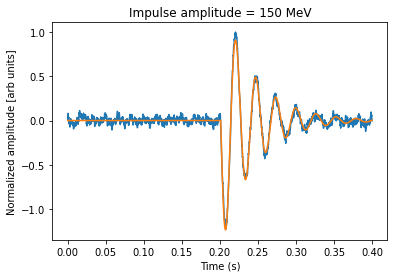

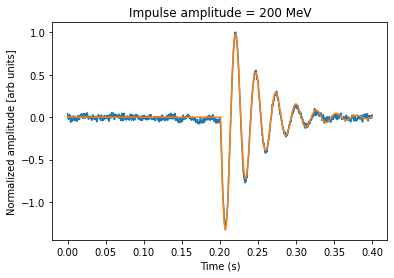

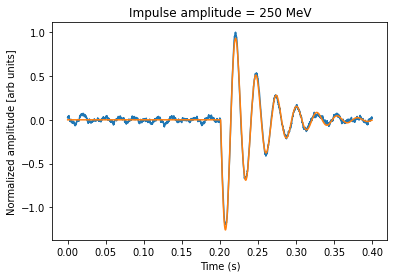

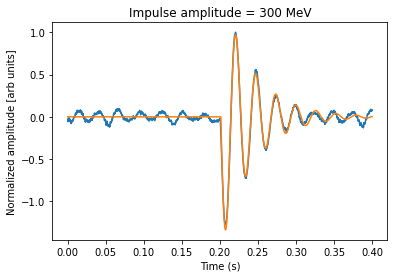

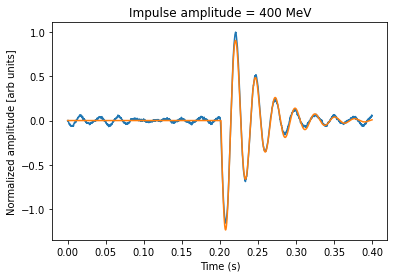

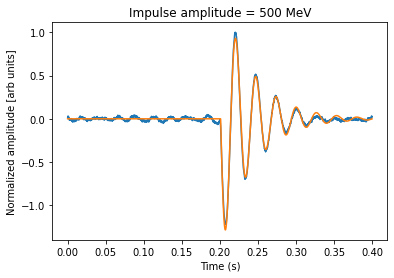

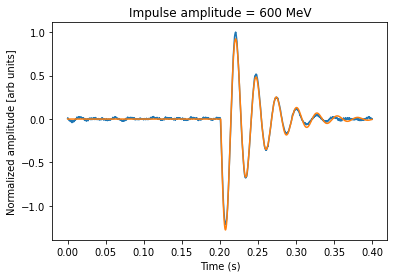

In [5]:
# calculate the pulse tempates by averaging all calibration files
importlib.reload(bu)
template_dict, template_dict_fit = bu.get_average_template(calib_file_dict, make_plots=True, fit_pars=[-1,2*np.pi*30,10,0.20])

/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis/bead_utils.py:543: RuntimeWarning: invalid value encountered in sqrt
  corr_data = np.sqrt(sp.filtfilt(bcorr, acorr, corr_data**2))


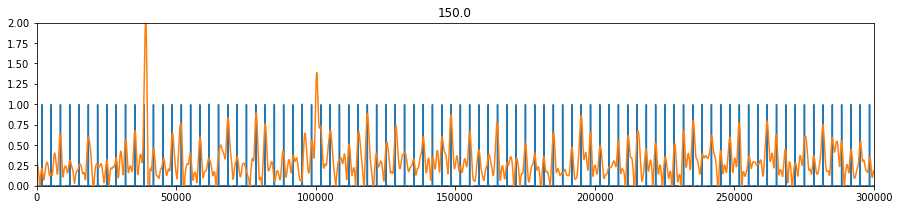

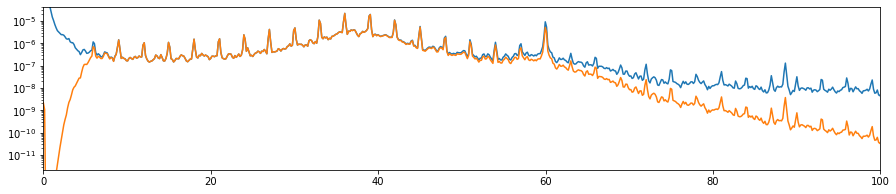

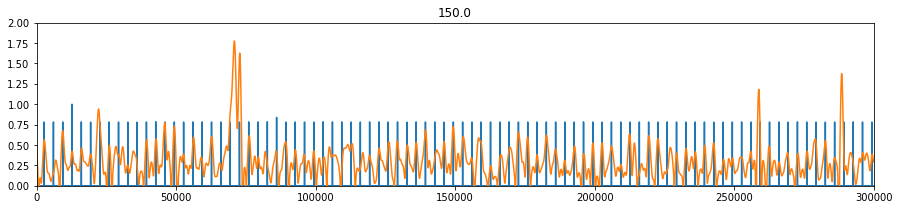

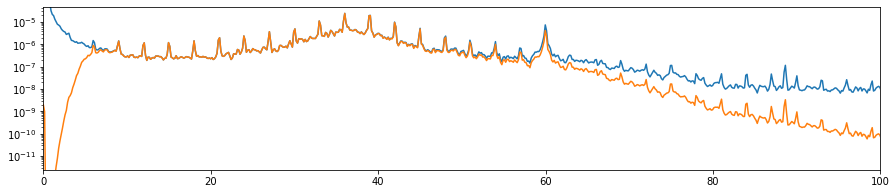

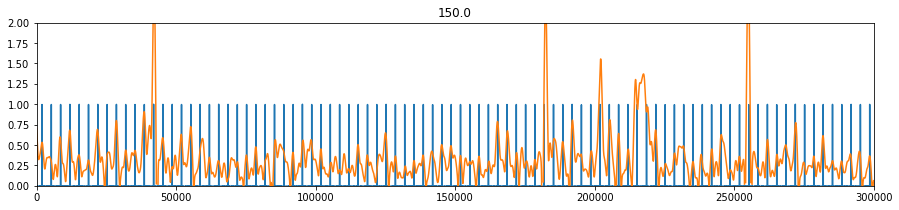

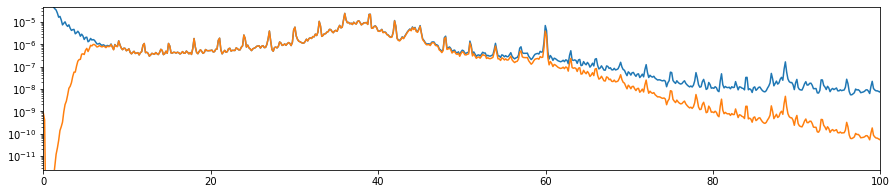

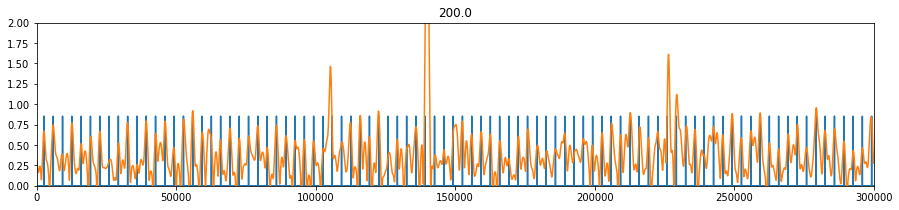

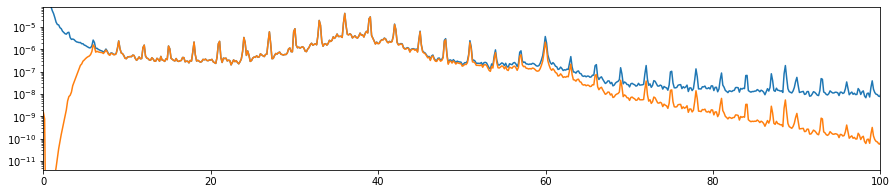

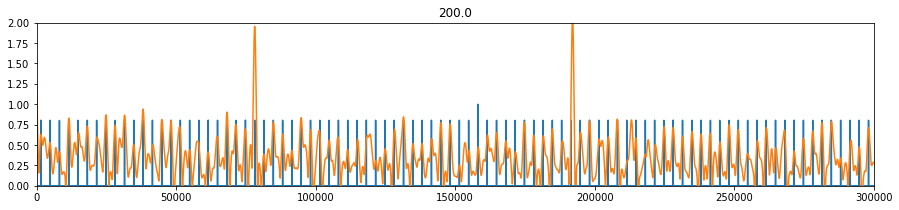

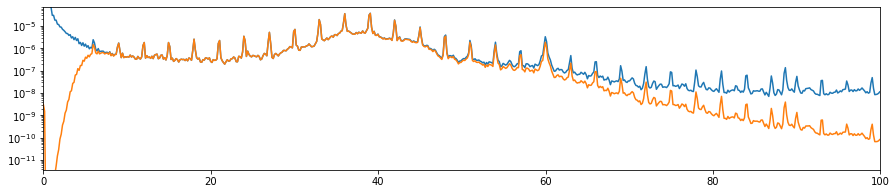

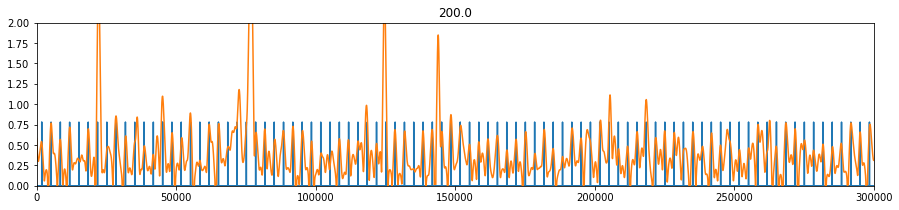

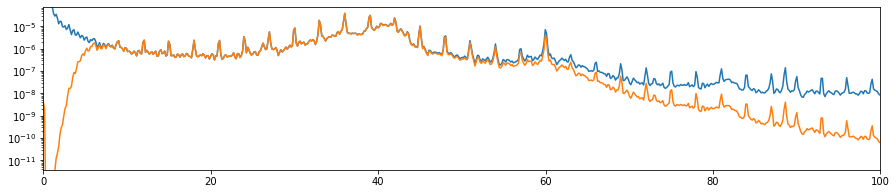

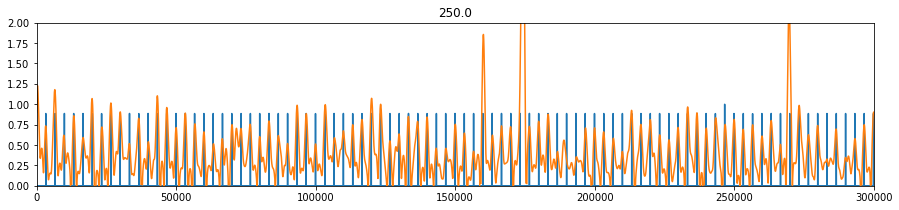

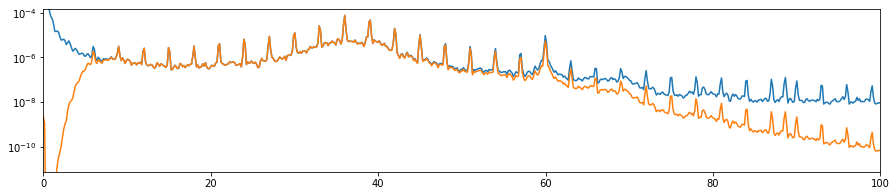

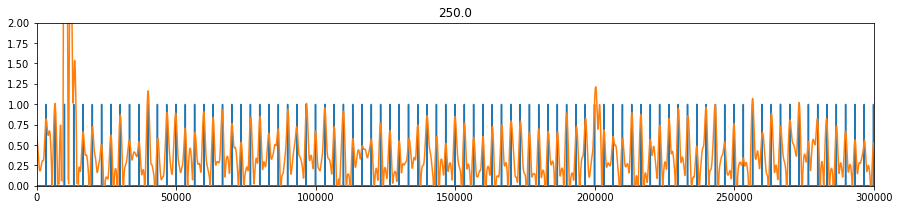

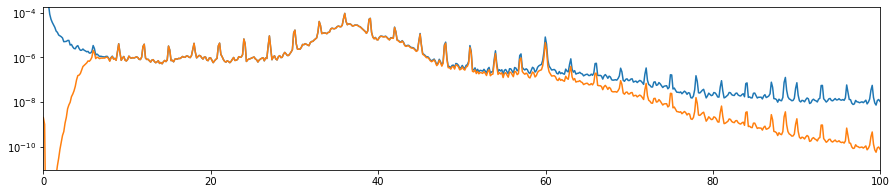

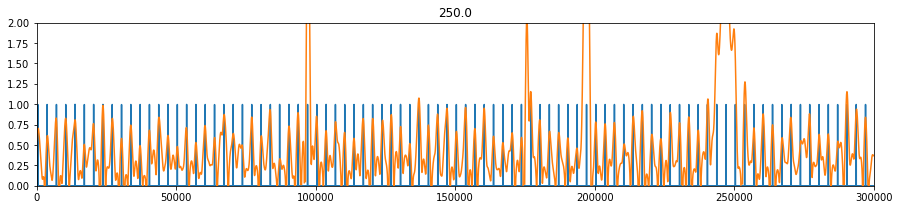

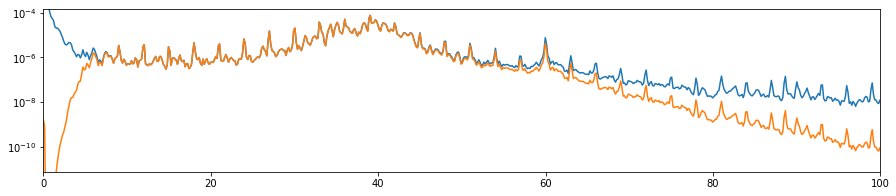

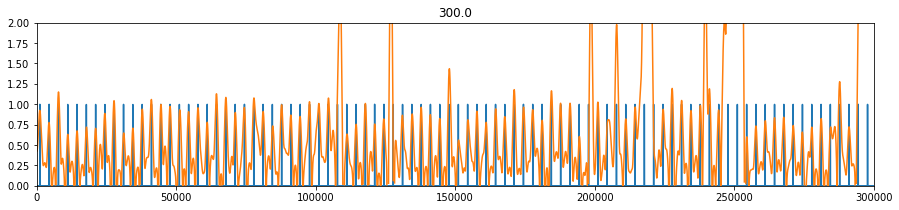

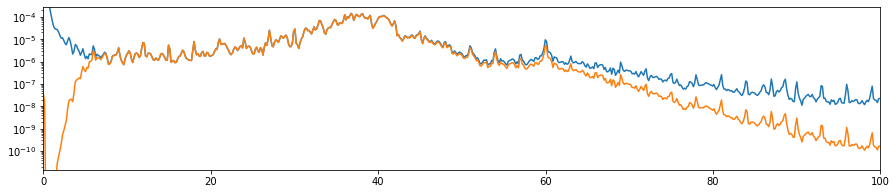

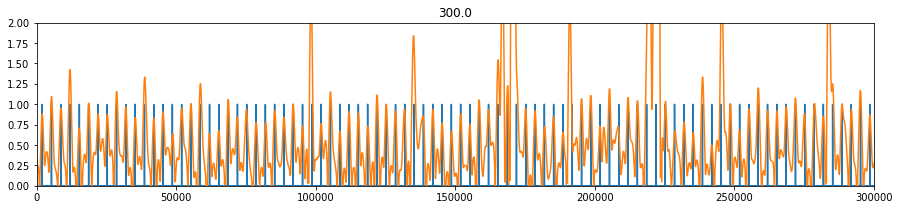

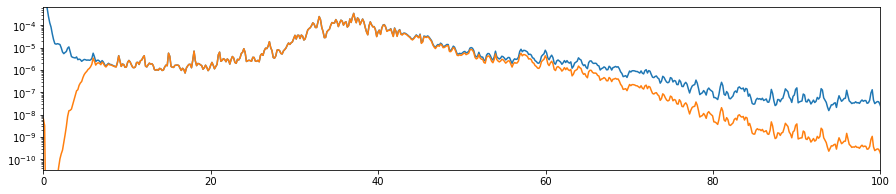

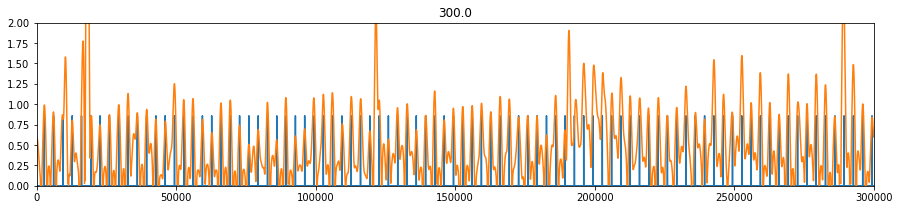

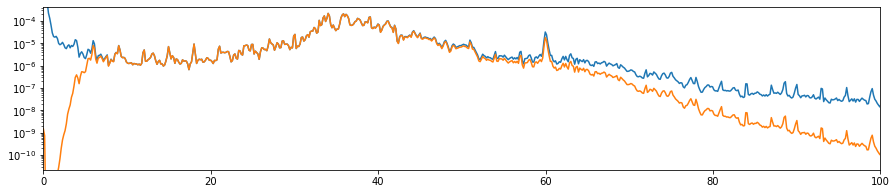

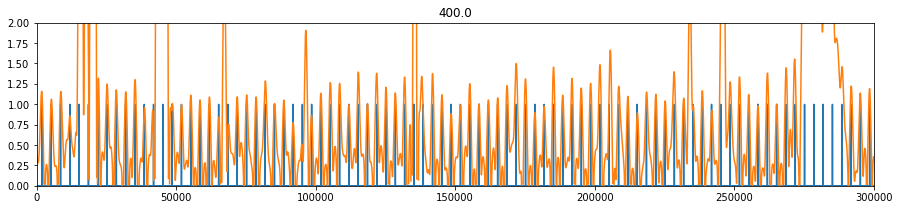

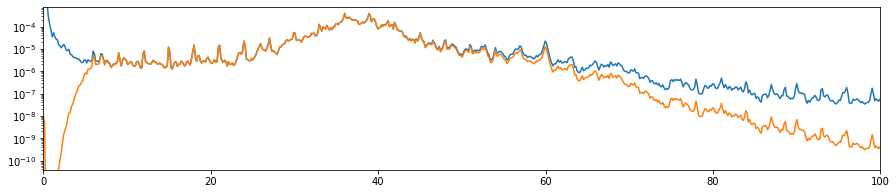

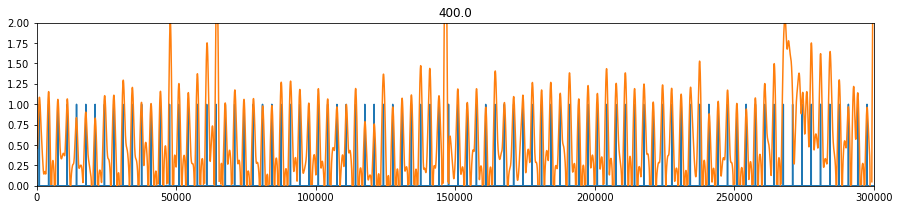

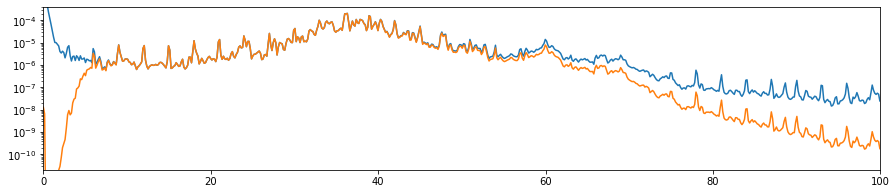

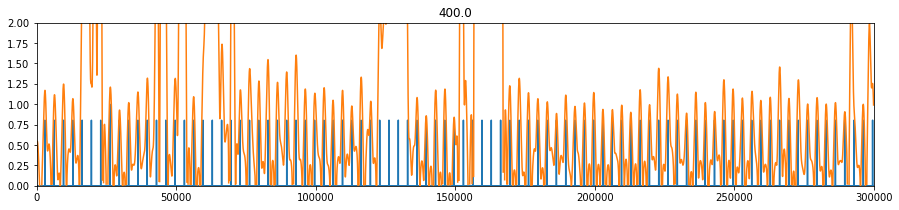

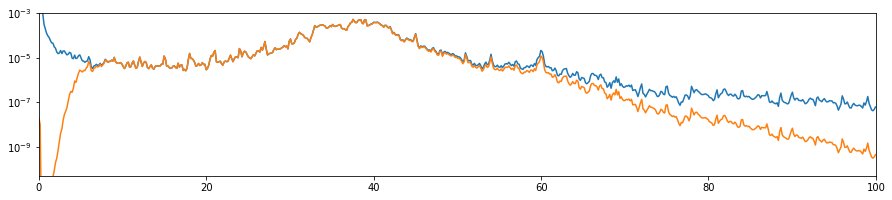

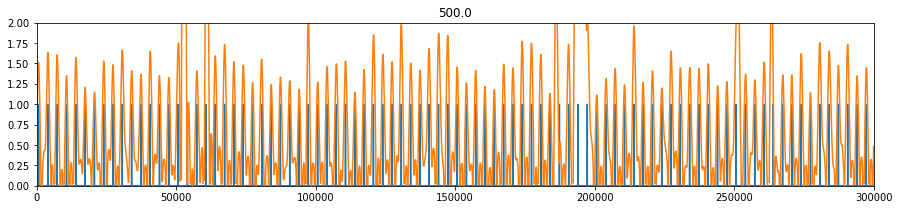

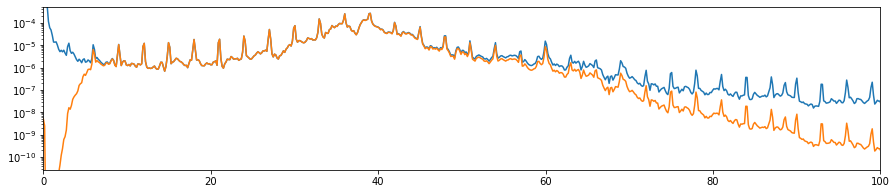

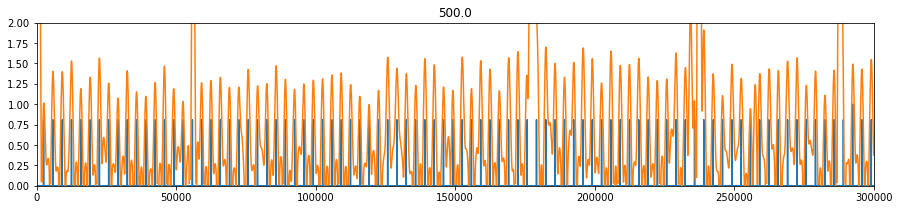

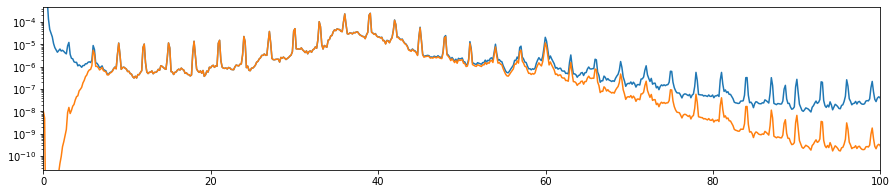

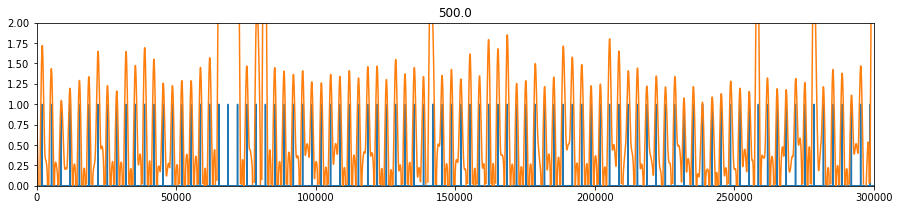

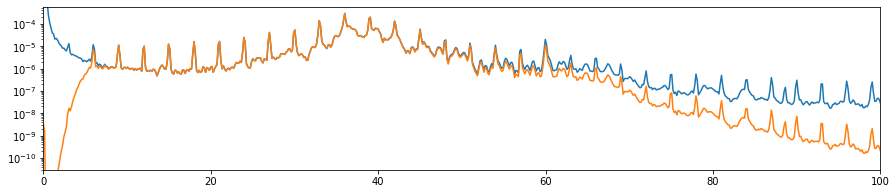

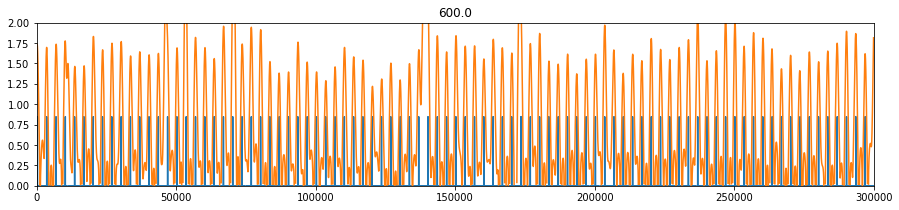

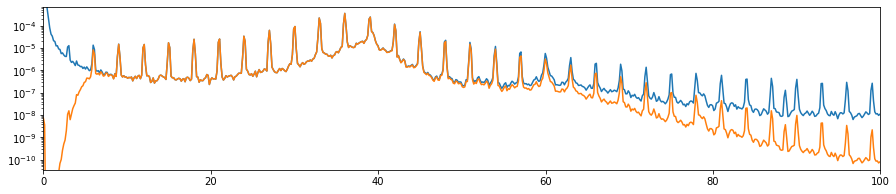

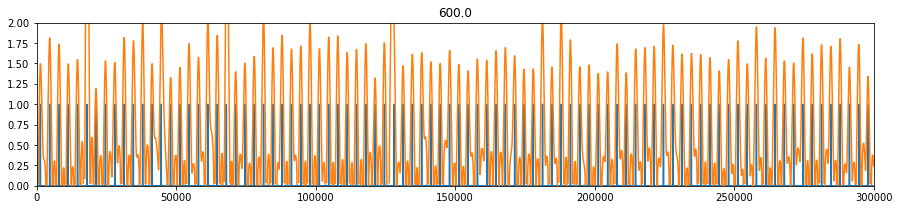

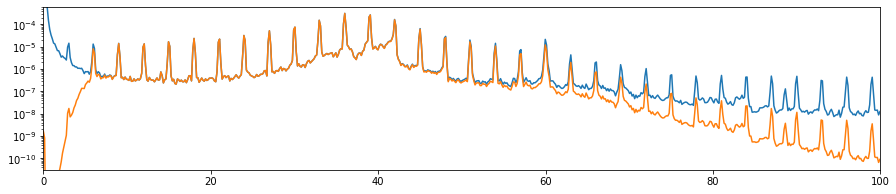

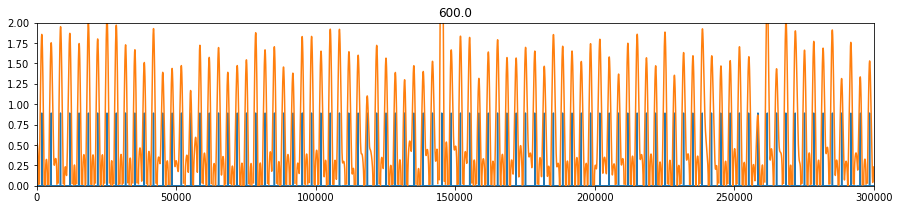

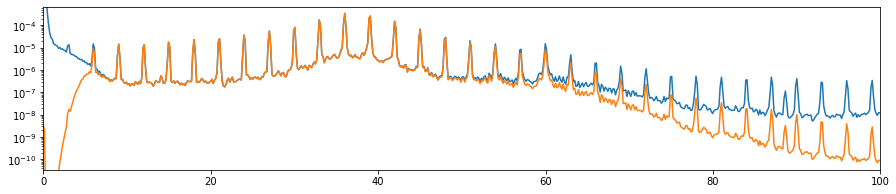

In [6]:
## run a matched filter (assuming white noise on the calibration files)

importlib.reload(bu)
## [5,50]
filt_amps = bu.correlation_filt(calib_file_dict, template_dict_fit, bandpass=[5,70], notch_list = [], make_plots=True)

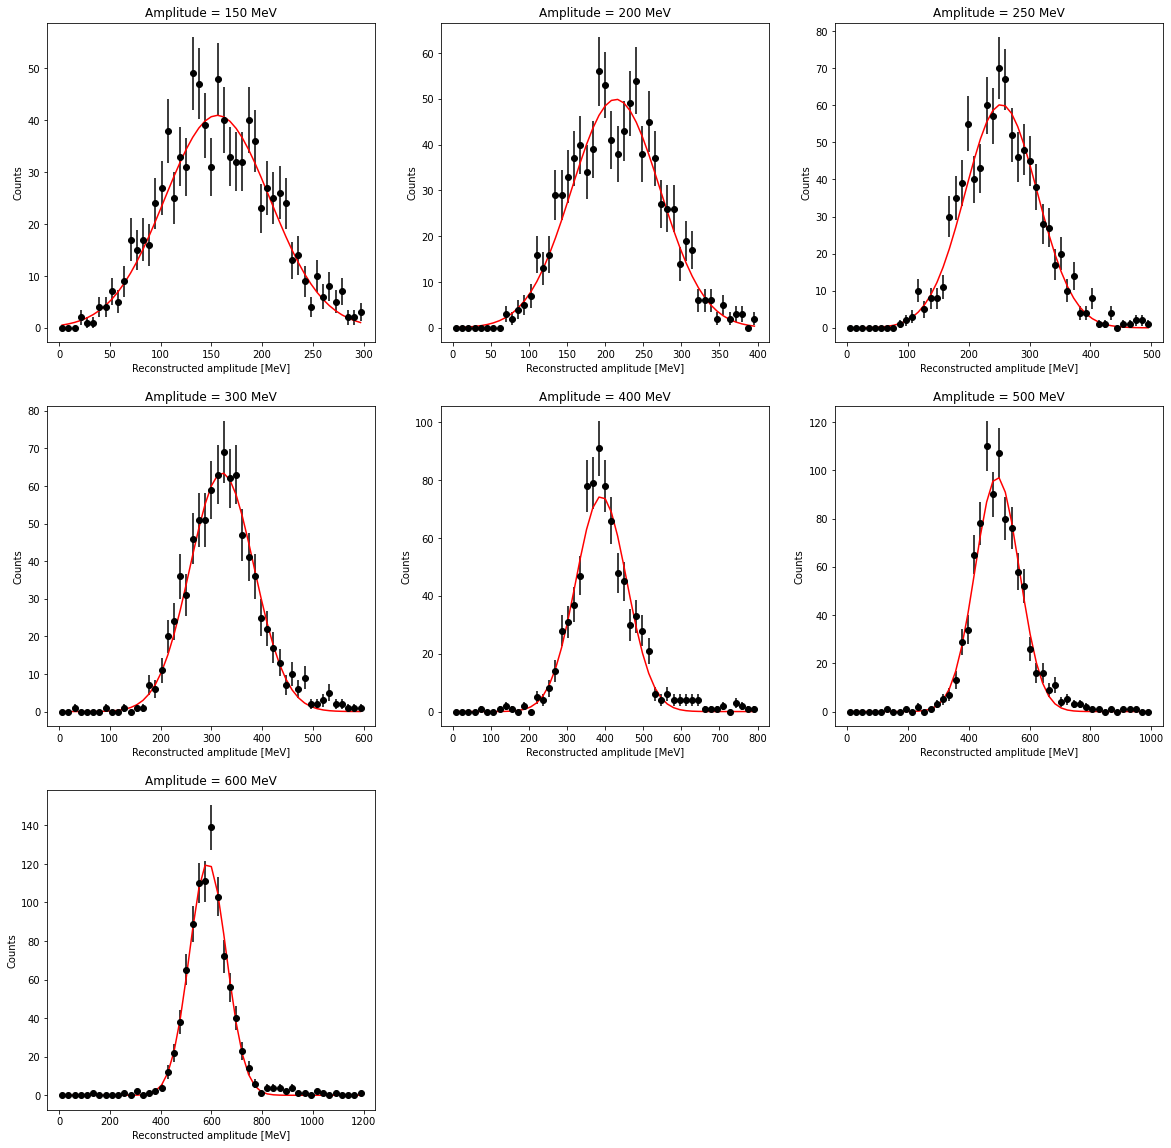

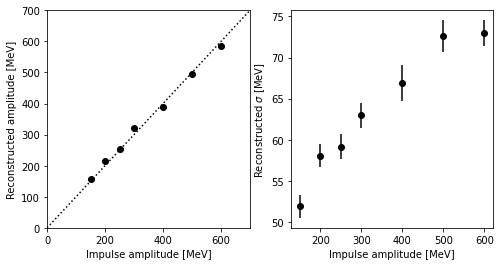

In [8]:
amp_bins = np.arange(0,100,2)

#cal_fac = 79

cal_fac = 70

def gauss_fun(x,A,mu,sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

fit_vals = []
plt.figure(figsize=(20,20))
for j,amp in enumerate(filt_amps.keys()):
    amp_bins = np.linspace(0,2*amp,50)
    hh,be = np.histogram(filt_amps[amp]*cal_fac, bins=amp_bins)
    bc = be[:-1] + np.diff(be)/2

    ## gauss fit
    err = np.sqrt(hh)
    err[err==0] = 1
    gp, gcov = sp.curve_fit(gauss_fun, bc, hh, sigma=err, p0=[1, amp, 50])

    ## amplitude, mean, mean_err, sig, sig_err
    fit_vals.append([amp, gp[1], np.sqrt(gcov[1,1]), gp[2], np.sqrt(gcov[2,2])])

    plt.subplot(3,3,j+1)
    plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='ko', label=amp)
    plt.plot(bc, gauss_fun(bc, *gp), 'r', label="$\mu$ = %.1f MeV,\n$\sigma$=%.1fMeV"%(gp[1], gp[2]))
    plt.title("Amplitude = %d MeV"%amp)
    plt.ylabel("Counts")
    plt.xlabel("Reconstructed amplitude [MeV]")
    #plt.legend()

fit_vals = np.array(fit_vals)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.errorbar(fit_vals[:,0], fit_vals[:,1], yerr=fit_vals[:,2], fmt='ko')
xmin, xmax = 0, 700
plt.plot([xmin, xmax], [xmin, xmax], 'k:')
plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
plt.xlabel("Impulse amplitude [MeV]")
plt.ylabel("Reconstructed amplitude [MeV]")

plt.subplot(1,2,2)
plt.errorbar(fit_vals[:,0], fit_vals[:,3], yerr=fit_vals[:,4], fmt='ko')
plt.xlabel("Impulse amplitude [MeV]")
plt.ylabel("Reconstructed $\sigma$ [MeV]")

plt.show()